Params: [200, 350, 500, 200, 350, 500, 0, 10, 20, 15, 25, 35] => MSE: 0.7127092718091029
Params: [np.int64(259), np.int64(328), np.int64(528), np.int64(219), np.int64(367), np.int64(460), np.int64(2), np.int64(8), np.int64(17), np.int64(17), np.int64(21), np.int64(41)] => MSE: 0.8913717437987233
Params: [np.int64(288), np.int64(300), np.int64(549), np.int64(223), np.int64(392), np.int64(451), np.int64(0), np.int64(10), np.int64(21), np.int64(10), np.int64(30), np.int64(33)] => MSE: 0.9005772621277758
Params: [np.int64(118), np.int64(393), np.int64(488), np.int64(297), np.int64(370), np.int64(536), np.int64(3), np.int64(10), np.int64(15), np.int64(19), np.int64(26), np.int64(36)] => MSE: 0.7239348299602275
Params: [np.int64(103), np.int64(335), np.int64(474), np.int64(237), np.int64(391), np.int64(533), np.int64(1), np.int64(9), np.int64(18), np.int64(18), np.int64(24), np.int64(33)] => MSE: 0.7397127997692801
Params: [np.int64(214), np.int64(305), np.int64(534), np.int64(190), np.int64

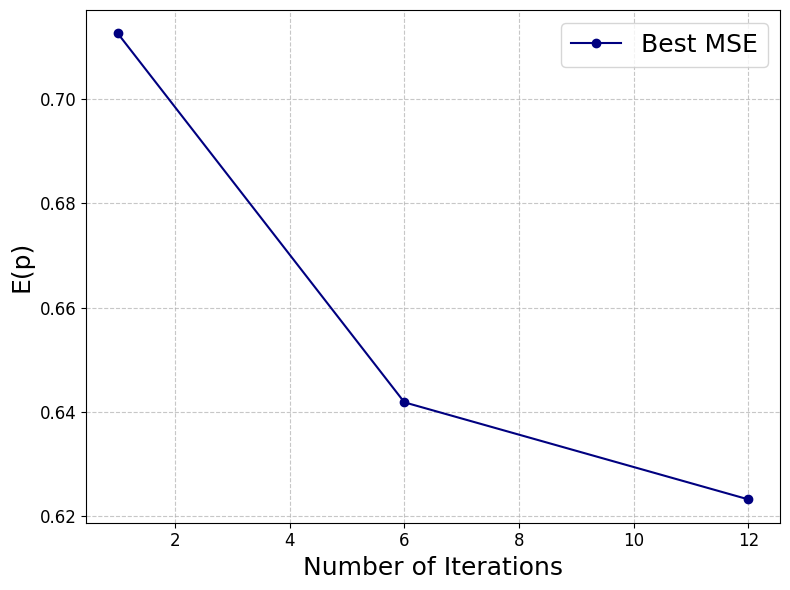

In [5]:
# Path & Libraries

import sys
import os
import warnings
from joblib import Parallel, delayed
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import zipfile
import numpy as np

sys.path.append(os.path.abspath('dss'))
warnings.filterwarnings('ignore')

# Load Data & Model
rules_excel_path = '../data/dss_rules.xlsx'
sheet_names = ['Rules', 'Crispy Values', 'Fuzzy Values']
rules_df, crispy_df, fuzzy_df = [pd.read_excel(rules_excel_path, sheet_name=sheet) for sheet in sheet_names]
rules_df = rules_df.iloc[:, :].rename(columns=lambda x: x.lower().replace(' ', '_'))
fuzzy_df = fuzzy_df.iloc[:, :].rename(columns=lambda x: x.lower().replace(' ', '_'))

zip_path = 'models_ml.zip'
model_name = 'global_xgb.pkl'
with zipfile.ZipFile(zip_path, 'r') as zipf:
    with zipf.open(model_name) as file:
        xgb_model = pickle.load(file)

# Fuzzy Input Variables
input_variables = rules_df.columns[:-1].tolist()
crispy_input = crispy_df.iloc[:, 0].dropna().values
crispy_output = crispy_df.iloc[:, 1].dropna().values

fuzzy_values = fuzzy_df.values
fuzzy_min = fuzzy_values[0]
fuzzy_max = fuzzy_values[1]
num_classes = fuzzy_values[2].astype(int)

feature_dict = {}
universe_dict = {}

for var, min_val, max_val, num_class in zip(input_variables, fuzzy_min[:-1], fuzzy_max[:-1], num_classes[:-1]):
    feature_dict[var] = {}
    fraction_range = (max_val - min_val) / (num_class - 1)
    universe = np.arange(min_val - 2 * fraction_range, max_val + 2 * fraction_range + 1, 1)
    universe_dict[var] = universe
    for i, term_name in enumerate(crispy_input):
        if i == 0:
            feature_dict[var] = ctrl.Antecedent(universe, var)
            term_range = [min_val - 2 * fraction_range, min_val - 2 * fraction_range, min_val, min_val + fraction_range]
            feature_dict[var][term_name] = fuzz.trapmf(feature_dict[var].universe, term_range)
        elif i == num_class - 1:
            term_range = [max_val - fraction_range, max_val, max_val + 2 * fraction_range, max_val + 2 * fraction_range]
            feature_dict[var][term_name] = fuzz.trapmf(feature_dict[var].universe, term_range)
        else:
            term_range = [min_val + (i - 1) * fraction_range, min_val + i * fraction_range,
                          min_val + (i + 1) * fraction_range]
            feature_dict[var][term_name] = fuzz.trimf(feature_dict[var].universe, term_range)

# Fuzzy Output Variable

output_variable = rules_df.columns[-1]

var = output_variable
min_val = fuzzy_min[-1]
max_val = fuzzy_max[-1]
num_class = num_classes[-1]

feature_dict[var] = {}
fraction_range = (max_val - min_val) / (num_class - 1)
universe = np.arange(min_val - 2 * fraction_range, max_val + 2 * fraction_range + 1, 1)
universe_dict[var] = universe
for i, term_name in enumerate(crispy_output):
    if i == 0:
        feature_dict[var] = ctrl.Consequent(universe, var)
        term_range = [min_val - 2 * fraction_range, min_val - 2 * fraction_range, min_val, min_val + fraction_range]
        feature_dict[var][term_name] = fuzz.trapmf(feature_dict[var].universe, term_range)
    elif i == num_class - 1:
        term_range = [max_val - fraction_range, max_val, max_val + 2 * fraction_range, max_val + 2 * fraction_range]
        feature_dict[var][term_name] = fuzz.trapmf(feature_dict[var].universe, term_range)
    else:
        term_range = [min_val + (i - 1) * fraction_range, min_val + i * fraction_range,
                      min_val + (i + 1) * fraction_range]
        feature_dict[var][term_name] = fuzz.trimf(feature_dict[var].universe, term_range)

# Fuzzy Rules

rule_dict = {}

n_rules = rules_df.shape[0]
n_features = rules_df.shape[1]

for i in range(n_rules):
    term_input = None
    term_output = None

    for j in range(n_features):

        if j == 0:
            term_input = feature_dict[rules_df.columns.tolist()[j]][rules_df.iloc[i, j]]

        elif j == n_features - 1:
            term_output = feature_dict[rules_df.columns.tolist()[j]][rules_df.iloc[i, j]]

        elif not pd.isna(rules_df.iloc[i, j]):
            term_input = term_input & feature_dict[rules_df.columns.tolist()[j]][rules_df.iloc[i, j]]

        else:
            continue

    rule_dict[i] = ctrl.Rule(antecedent=term_input, consequent=term_output)

# No Defuzzification Needed

# Control System Creation & Simulation & Saving

rule_vector = []
for i in range(len(rule_dict)):
    rule_vector.append(rule_dict[i])

dss_ctrl = ctrl.ControlSystem(rule_vector)
dss = ctrl.ControlSystemSimulation(dss_ctrl, flush_after_run=100 * 100 + 1)


# Load validation data
val_data = pd.read_csv('../data/val_data.csv')
val_data['Decision'] = val_data['Decision'].map({
    'Not Recommended': 0.0,
    'Half Turn': 1.0,
    'Single Turn': 2.0,
    'Double Turn': 3.0
}).astype(float)

def update_fuzzy_system(params):
    lt_low, lt_med, lt_hgh, pt_low, pt_med, pt_hgh, rain_low, rain_med, rain_hgh, tmp_low, tmp_med, tmp_hgh = params

    feature_dict['last_avg_tensiometer']['Low'] = fuzz.trapmf(feature_dict['last_avg_tensiometer'].universe,
                                                              [-100.0, -100.0, lt_low, lt_med])
    feature_dict['last_avg_tensiometer']['Medium'] = fuzz.trimf(feature_dict['last_avg_tensiometer'].universe,
                                                                [lt_low, lt_med, lt_hgh])
    feature_dict['last_avg_tensiometer']['High'] = fuzz.trapmf(feature_dict['last_avg_tensiometer'].universe,
                                                               [lt_med, lt_hgh, 800.0, 800.0])

    feature_dict['predicted_avg_tensiometer']['Low'] = fuzz.trapmf(feature_dict['predicted_avg_tensiometer'].universe,
                                                                   [-100.0, -100.0, pt_low, pt_med])
    feature_dict['predicted_avg_tensiometer']['Medium'] = fuzz.trimf(feature_dict['predicted_avg_tensiometer'].universe,
                                                                     [pt_low, pt_med, pt_hgh])
    feature_dict['predicted_avg_tensiometer']['High'] = fuzz.trapmf(feature_dict['predicted_avg_tensiometer'].universe,
                                                                    [pt_med, pt_hgh, 800.0, 800.0])

    feature_dict['predicted_rain_amount']['Low'] = fuzz.trapmf(feature_dict['predicted_rain_amount'].universe,
                                                               [-20.0, -20.0, rain_low, rain_med])
    feature_dict['predicted_rain_amount']['Medium'] = fuzz.trimf(feature_dict['predicted_rain_amount'].universe,
                                                                 [rain_low, rain_med, rain_hgh])
    feature_dict['predicted_rain_amount']['High'] = fuzz.trapmf(feature_dict['predicted_rain_amount'].universe,
                                                                [rain_med, rain_hgh, 40.0, 40.0])

    feature_dict['predicted_max_temperature']['Low'] = fuzz.trapmf(feature_dict['predicted_max_temperature'].universe,
                                                                   [-5.0, -5.0, tmp_low, tmp_med])
    feature_dict['predicted_max_temperature']['Medium'] = fuzz.trimf(feature_dict['predicted_max_temperature'].universe,
                                                                     [tmp_low, tmp_med, tmp_hgh])
    feature_dict['predicted_max_temperature']['High'] = fuzz.trapmf(feature_dict['predicted_max_temperature'].universe,
                                                                    [tmp_med, tmp_hgh, 55.0, 55.0])


def objective(params):
    lt_low, lt_med, lt_hgh, pt_low, pt_med, pt_hgh, rain_low, rain_med, rain_hgh, tmp_low, tmp_med, tmp_hgh = params

    if not (lt_low <= lt_med <= lt_hgh):
        return 1e100
    if not (pt_low <= pt_med <= pt_hgh):
        return 1e100
    if not (rain_low <= rain_med <= rain_hgh):
        return 1e100
    if not (tmp_low <= tmp_med <= tmp_hgh):
        return 1e100

    update_fuzzy_system(params)

    rule_dict = {}

    n_rules = rules_df.shape[0]
    n_features = rules_df.shape[1]

    for i in range(n_rules):
        term_input = None
        term_output = None

        for j in range(n_features):

            if j == 0:
                term_input = feature_dict[rules_df.columns.tolist()[j]][rules_df.iloc[i, j]]

            elif j == n_features - 1:
                term_output = feature_dict[rules_df.columns.tolist()[j]][rules_df.iloc[i, j]]

            elif not pd.isna(rules_df.iloc[i, j]):
                term_input = term_input & feature_dict[rules_df.columns.tolist()[j]][rules_df.iloc[i, j]]

            else:
                continue

        rule_dict[i] = ctrl.Rule(antecedent=term_input, consequent=term_output)

    rule_vector = []
    for i in range(len(rule_dict)):
        rule_vector.append(rule_dict[i])

    dss_ctrl = ctrl.ControlSystem(rule_vector)
    dss = ctrl.ControlSystemSimulation(dss_ctrl, flush_after_run=100 * 100 + 1)

    predictions = []

    for i in range(len(val_data)):
        dss.input['last_avg_tensiometer'] = val_data['Last Avg Tensiometer'][i]
        dss.input['predicted_avg_tensiometer'] = val_data['Predicted Avg Tensiometer'][i]
        dss.input['predicted_rain_amount'] = val_data['Predicted Rain Amount'][i]
        dss.input['predicted_max_temperature'] = val_data['Predicted Max Temperature'][i]
        dss.compute()
        predictions.append(dss.output['decision'])

    mse = mean_squared_error(val_data['Decision'], predictions)
    print(f"Params: {params} => MSE: {mse}")

    return mse

from skopt import gp_minimize  # Bayesian optimization
from skopt.space import Real, Integer, Categorical
# Define the parameter space for Bayesian Optimization
space = [
    Integer(100, 300, name='lt_low'),
    Integer(300, 450, name='lt_med'),
    Integer(450, 550, name='lt_hgh'),
    Integer(100, 300, name='pt_low'),
    Integer(300, 450, name='pt_med'),
    Integer(450, 550, name='pt_hgh'),
    Integer(0, 5, name='rain_low'),
    Integer(5, 15, name='rain_med'),
    Integer(15, 30, name='rain_hgh'),
    Integer(10, 20, name='tmp_low'),
    Integer(20, 30, name='tmp_med'),
    Integer(30, 45, name='tmp_hgh'),
]

# Perform Bayesian optimization using gp_minimize
result = gp_minimize(objective, space, n_calls=12, random_state=42, x0=[200, 350, 500, 200, 350, 500, 0, 10, 20, 15, 25, 35])

# Best parameters and score
print("\nBest parameters:", result.x)
print(f"Best score (error): {result.fun}")

# Identificare gli indici delle iterazioni in cui il MSE è migliorato
improved_indices = [0]  # Il primo punto è sempre incluso
for i in range(1, len(result.func_vals)):
    if result.func_vals[i] < result.func_vals[improved_indices[-1]]:
        improved_indices.append(i)

# Estrarre iterazioni e valori di MSE corrispondenti
iterations_filtered = np.array(improved_indices) + 1
best_mse_filtered = np.array(result.func_vals)[improved_indices]

# Stile del grafico
plt.figure(figsize=(8, 6))
plt.plot(iterations_filtered, best_mse_filtered, marker='o', linestyle='-', color='navy', label='Best MSE')
plt.xlabel('Number of Iterations', fontsize=18)
plt.ylabel('E(p)', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=18)

# Modifica dimensione numeri sugli assi
plt.tick_params(axis='both', which='major', labelsize=12)

# Salvataggio del grafico
output_path = 'bayesian_optimization.png'
plt.tight_layout()
plt.savefig(output_path, dpi=400)


import pickle

best_params = result.x
print("\nBest parameters:", best_params)

best_params = [int(param) for param in best_params]
update_fuzzy_system(best_params)

rule_dict = {}

n_rules = rules_df.shape[0]
n_features = rules_df.shape[1]

for i in range(n_rules):
    term_input = None
    term_output = None

    for j in range(n_features):
        if j == 0:
            term_input = feature_dict[rules_df.columns.tolist()[j]][rules_df.iloc[i, j]]
        elif j == n_features - 1:
            term_output = feature_dict[rules_df.columns.tolist()[j]][rules_df.iloc[i, j]]
        elif not pd.isna(rules_df.iloc[i, j]):
            term_input = term_input & feature_dict[rules_df.columns.tolist()[j]][rules_df.iloc[i, j]]
        else:
            continue

    rule_dict[i] = ctrl.Rule(antecedent=term_input, consequent=term_output)

# Crea il sistema di controllo fuzzy finale con le regole ottimizzate
rule_vector = [rule_dict[i] for i in range(len(rule_dict))]
dss_ctrl = ctrl.ControlSystem(rule_vector)
dss = ctrl.ControlSystemSimulation(dss_ctrl, flush_after_run=100 * 100 + 1)

# Salva il modello finale DSS
with open('model_dss2.pkl', 'wb') as f:
    pickle.dump(dss, f)

print("Best DSS model saved as 'model_dss.pkl'.")